In [50]:
import pystan
from pystan import StanModel
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from psis import psisloo 

In [40]:
projects = pd.read_csv("projects.csv", header=None)
display(HTML(projects.head(100).to_html(max_rows=100)))


/Users/juliushietala/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,NaN,NaN,NaN,NaN
1,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
2,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 03:43:57,30000,2017-09-02 04:43:57,2421,failed,15,US,100,NaN,NaN,NaN,NaN
3,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
4,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
5,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
6,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN
7,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 18:30:44,1000,2014-12-01 18:30:44,1205,successful,16,US,1205,NaN,NaN,NaN,NaN
8,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17 19:05:12,25000,2016-02-01 20:05:12,453,failed,40,US,453,NaN,NaN,NaN,NaN
9,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000,2014-04-24 18:14:43,8233,canceled,58,US,8233,NaN,NaN,NaN,NaN


### Run below cells after making changes

In [96]:
pm = np.array(projects) #All project data
pm = np.delete(pm, (0), axis=0) #Delete top row
pm = np.delete(pm, (0,1,2,3,4,5,7,11,12,13,14,15,16), axis=1) #Delete non needed columns

print(pm.shape) #Shape of the data


(378648, 4)


In [97]:
success_idx = pm[:,2] == "successful" #Tuple of all indexes that are successful
failed_idx = pm[:,2] == "failed" #Tuple of all indexes that failed
print("Data points before processing: ",pm.shape[0])

#Remove all rows where the end result is not successful or failed
remove_idx = np.where(np.logical_or(success_idx,failed_idx)==False)
pm = np.delete(pm, remove_idx, axis=0)
print("Data points after removing non success/fail cases: ",pm.shape[0],"\n")

#Find new indexes for success and fail cases
success_idx = pm[:,2] == "successful"
failed_idx = pm[:,2] == "failed"

#Replace failed values with 0, success with 0 and convert whole matrix to numeric values
pm[success_idx,2] = 1
pm[failed_idx,2] = 0
pm = pm.astype(float)

#Remove all rows where the backers/pledged count is below a threshold
remove_idx = np.where(pm[:,3] < 10)
pm = np.delete(pm, remove_idx, axis=0)

unique_backers_count = np.unique(pm[:,3]).shape[0] #Unique backers amount count
evaluated_projets = pm.shape[0] #All projects evaluated

print("Data points after removing data not falling to minimum threshold: ",evaluated_projets)
print("Unique values for backers count: ", unique_backers_count)



Data points before processing:  378648
Data points after removing non success/fail cases:  331033 

Data points after removing data not falling to minimum threshold:  186228
Unique values for backers count:  3916


In [98]:
groups, inverse, group_amounts= np.unique(pm[:,3], return_inverse=True, return_counts=True) 
#groups = backer count for each group
#inverse = mapping from original array to unique indexes
# group_amounts = how many items are there total per group

success_per_group = np.zeros((unique_backers_count,1)) #Empty array for success amounts per unique group
success_column = pm[:,2] #Column where the success/fail values live

In [99]:
s = 0
f = 0
for i in range(evaluated_projets):
    if (success_column[i]==1): #Check whether a particular project has succeeded
        success_per_group[inverse[i]] = success_per_group[inverse[i],0] + 1 #If yes, increment the success amount of the group
        s += 1
    else:
        f += 1

### Data analysis before fitting model

Backer counts histogram


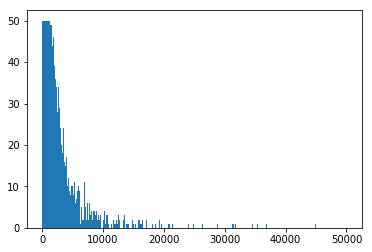

In [100]:
plt.hist(groups, bins=1000, range=[0,50000]);
print("Backer counts histogram")

Project goals histogram


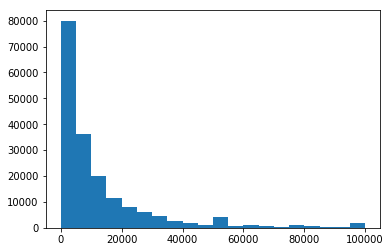

In [107]:
goals = pm[:,0]
print("Project goals histogram")
plt.hist(goals, bins=20,range=[0,100000]);

Projects pledged histogram


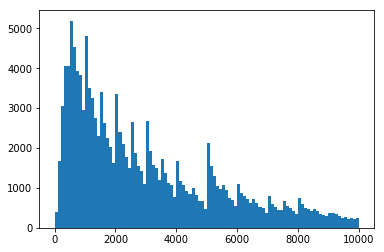

In [114]:
pledged = pm[:,1]
print("Projects pledged histogram")
plt.hist(pledged, bins=100,range=[0,10000]);

In [102]:
group_log_values = np.log(groups) #Backer counts in the log scale as we are using binomial logit
success_int = success_per_group.astype(int)

project_stan_data = {
    'N': unique_backers_count,
    'x': np.asarray(group_log_values),
    'n': np.asarray(group_amounts),
    'y': np.asarray(success_int[:,0])
}

In [103]:
stan_content = """

data {
    int N; // amount of groups
    vector[N] x; // backers per group
    int n[N]; //projects per group
    int y[N]; // amount of successful projects per group
}

parameters {
    real alpha;
    real beta;
}

model {
    y ~ binomial_logit(n, alpha + beta*x);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i],alpha + beta*x[i]);
  }
}


"""

stan_file_sepa = open("model.stan", "w")
stan_file_sepa.write(stan_content)
stan_file_sepa.close()

In [49]:
model = pystan.StanModel(file='model.stan')
fit = model.sampling(data=project_stan_data)
samples = fit.extract(permuted=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_20d7d5ad881218ba3bfa1868c44bbebe NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_20d7d5ad881218ba3bfa1868c44bbebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha           -3.3  8.3e-4   0.02  -3.35  -3.32   -3.3  -3.28  -3.25    830    1.0
beta            1.06  2.2e-4 6.4e-3   1.05   1.06   1.06   1.07   1.08    839    1.0
log_lik[0]    -78.66    0.12   3.66 -86.08 -81.13 -78.61 -76.18 -71.37    971    1.0
log_lik[1]    -41.96    0.08   2.42 -46.88 -43.61 -41.92 -40.32 -37.17    998    1.0
log_lik[2]    -33.25    0.06   2.02 -37.36 -34.62 -33.21 -31.88 -29.32   1028    1.0
log_lik[3]    -30.68    0.06   1.84 -34.41 -31.94 -30.64 -29.44 -27.13   1060    1.0
log_lik[4]    -17.95    0.04   1.26  -20.5  -18.8 -17.92  -17.1 -15.55   1099    1.0
log_lik[5]    -10.16    0.02   0.78 -11.75 -10.67 -10.13  -9.63  -8.69   1144    1.0
log_lik[6]     -6.24    0.01   0.42  -7.12  -6

### "LD-90"

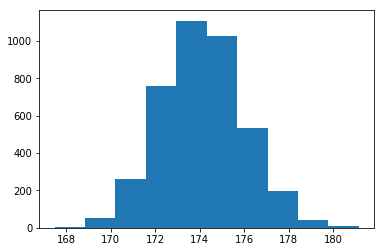

In [106]:
alpha_samples = samples['alpha']
beta_samples = samples['beta']

prob = np.exp((2.19-alpha_samples) / beta_samples) #Distribution when the probability of success is 90%
plt.hist(prob);

### PSIS-LOO analysis

In [51]:
print("PSIS-LOO value is", psisloo(samples['log_lik'])[0])

PSIS-LOO value is -2627.0555054493743



 k-values plotted


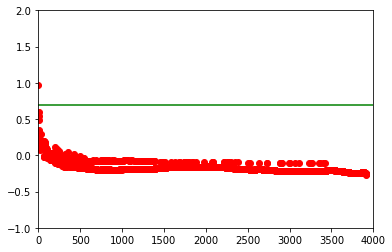

In [56]:
print("\n k-values plotted")
plt.plot(psisloo(samples['log_lik'])[2],'ro')
plt.axis([0, 4000, -1, 2])
plt.axhline(0.7, color='g');